In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as vale
import seaborn as sns
from sklearn import linear_model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels as stats
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
#!pip install --user pmdarima
import pmdarima as pmd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
calendario= pd.read_csv("calendar.csv")
cat_art=pd.read_csv("Datos_limpios/cat_articulos.csv",index_col=0)
cat_st=pd.read_csv("Datos_limpios/cat_tiendas.csv",index_col=0)
ventas_trans= pd.read_csv("Datos_limpios/ventas_transacc.csv",index_col=0)
submision=pd.read_csv("sample_submission.csv")
precio_venta=pd.read_csv("sell_prices.csv")

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# FASE 3: Modelación de los datos

Para efectos de no entrar en pronósticos de series de tiempo de demanda intermitente (que son más complicadas), las proyecciones se realizarán en los siguientes niveles de agregación: Departamento-Nacional, Departamento-Estatal, Categoría-Nacional, Categoría-Estatal, Categoría-Tienda, Tienda. Las frecuencias de las proyecciones se indicarán en cada punto.

Administra los datos de manera que tengas ventas a nivel semanal y mensual a niveles de agregación anteriormente mencionados. Además de la suma de las ventas durante el periodo de tiempo, es recomendable también considerar lo siguiente dentro de las variables de interés:

In [3]:
#print(cat_art)
#print(ventas_trans)

#print(calendario)
dep_nacional= cat_art.merge(ventas_trans[["sales","num_item_id","d"]],on="num_item_id")
dep_nacional= dep_nacional.merge(calendario[["date","month","year","d"]],on="d")
dep_mes=dep_nacional.groupby(["dept_id","month","year"])["sales"].sum().reset_index()
dep_mes["time"]= dep_mes["year"]+(dep_mes["month"]-1)/12
dep_mes=dep_mes[~((dep_mes["month"]==1)&(dep_mes["year"]==2011))]
dep_mes=dep_mes[~((dep_mes["month"]==4)&(dep_mes["year"]==2016))]

#dep_mes["ventas_unmes"]= 

print(dep_mes)

         dept_id  month  year  sales         time
1        FOODS_1      1  2012  70413  2012.000000
2        FOODS_1      1  2013  83481  2013.000000
3        FOODS_1      1  2014  79902  2014.000000
4        FOODS_1      1  2015  89446  2015.000000
5        FOODS_1      1  2016  98250  2016.000000
..           ...    ...   ...    ...          ...
443  HOUSEHOLD_2     12  2011  39751  2011.916667
444  HOUSEHOLD_2     12  2012  39231  2012.916667
445  HOUSEHOLD_2     12  2013  44235  2013.916667
446  HOUSEHOLD_2     12  2014  46064  2014.916667
447  HOUSEHOLD_2     12  2015  52949  2015.916667

[434 rows x 5 columns]


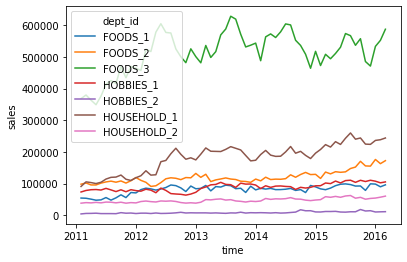

In [4]:
sns.lineplot(x="time",y="sales",hue="dept_id",data=dep_mes)

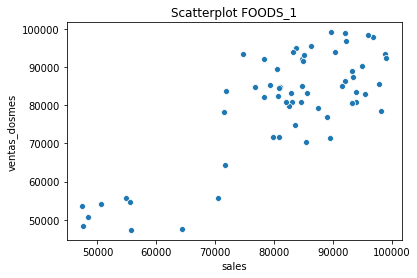

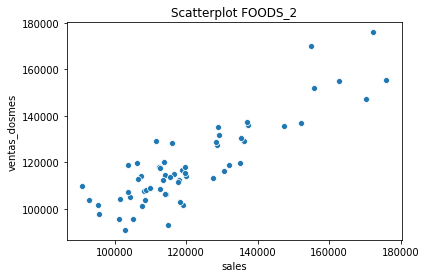

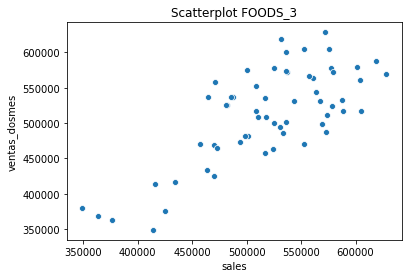

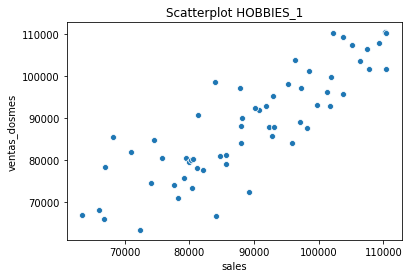

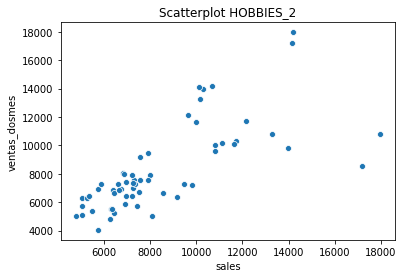

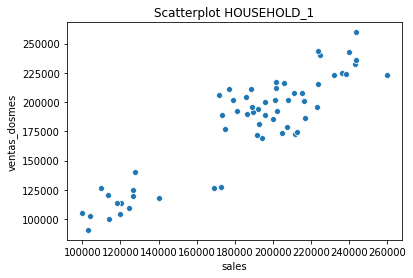

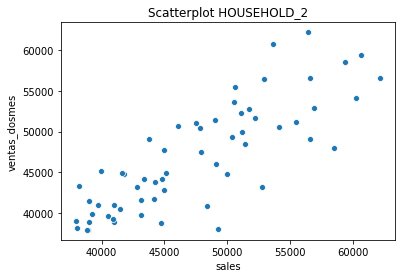

         dept_id  month  year  sales         time  ventas_unmes  ventas_dosmes
6        FOODS_1      2  2011  54155  2011.083333           NaN            NaN
12       FOODS_1      3  2011  53527  2011.166667       54155.0            NaN
18       FOODS_1      4  2011  50678  2011.250000       53527.0        54155.0
24       FOODS_1      5  2011  47358  2011.333333       50678.0        53527.0
29       FOODS_1      6  2011  48418  2011.416667       47358.0        50678.0
..           ...    ...   ...    ...          ...           ...            ...
442  HOUSEHOLD_2     11  2015  50509  2015.833333       56392.0        53675.0
447  HOUSEHOLD_2     12  2015  52949  2015.916667       50509.0        56392.0
389  HOUSEHOLD_2      1  2016  54109  2016.000000       52949.0        50509.0
395  HOUSEHOLD_2      2  2016  56897  2016.083333       54109.0        52949.0
401  HOUSEHOLD_2      3  2016  60211  2016.166667       56897.0        54109.0

[434 rows x 7 columns]


In [5]:
dep_mes=dep_mes.sort_values(["dept_id","year","month"])
dep_mes["ventas_unmes"]= dep_mes.groupby("dept_id")["sales"].shift(1)
dep_mes["ventas_dosmes"]= dep_mes.groupby("dept_id")["sales"].shift(2)
departamento= dep_mes["dept_id"].unique()

for dep in departamento:
    sns.scatterplot(x="sales",y="ventas_dosmes",data=dep_mes[dep_mes["dept_id"]==dep]).set_title("Scatterplot "+ dep)
    plt.show()

print(dep_mes)

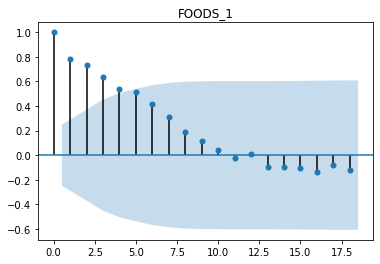

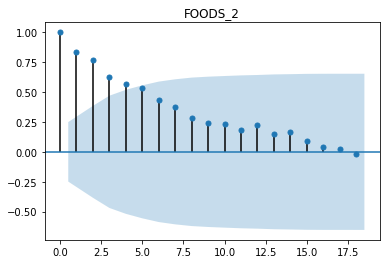

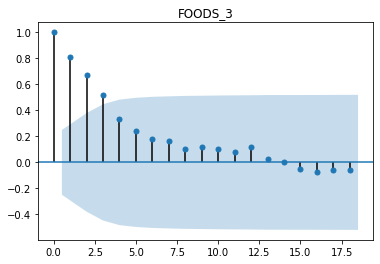

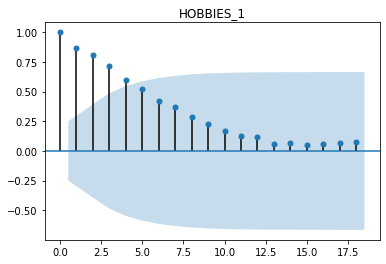

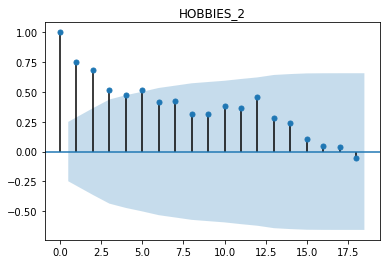

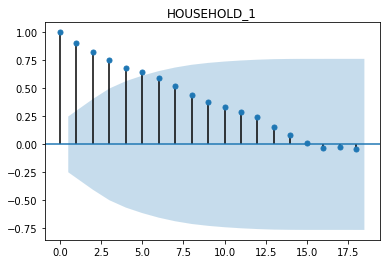

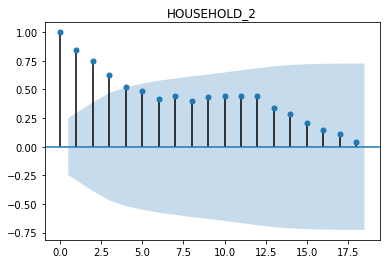

In [6]:
for dep in departamento:
    
    vents=dep_mes[dep_mes["dept_id"]==dep]["sales"]
    tsa.plot_acf(vents)
    plt.title(dep)
    vents

In [7]:
catalogo_semana=pd.DataFrame()
contador= 7
semana=52

for mes in range(1,13):
    if mes in [1,3,5,7,8,10,12]:
        dias= np.arange(1,32)
    elif mes in[4,6,9,11]:
        dias=np.arange(1,31)
    else:
        dias=np.arange(1,29)
    for dia in dias:
        cache=pd.Series({"mes":mes,"dia":dia,"semana":semana})
        catalogo_semana=catalogo_semana.append(cache,ignore_index=True)
        contador+=1
    
        if contador > 7:
            contador=1
            semana+=1
            if semana>52:
                semana=1




      year_final  semana      dept_id   sales         time
7           2011     5.0      FOODS_1   12625  2011.076923
8           2011     5.0      FOODS_2   25966  2011.076923
9           2011     5.0      FOODS_3  105156  2011.076923
10          2011     5.0    HOBBIES_1   19733  2011.076923
11          2011     5.0    HOBBIES_2     939  2011.076923
...          ...     ...          ...     ...          ...
1906        2016    16.0      FOODS_3  134477  2016.288462
1907        2016    16.0    HOBBIES_1   25013  2016.288462
1908        2016    16.0    HOBBIES_2    2614  2016.288462
1909        2016    16.0  HOUSEHOLD_1   53762  2016.288462
1910        2016    16.0  HOUSEHOLD_2   14559  2016.288462

[1904 rows x 5 columns]


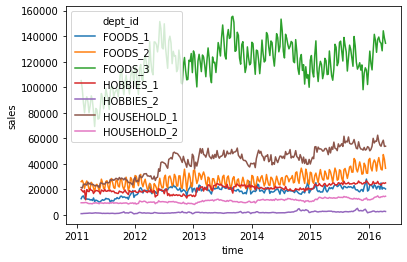

In [8]:
calendario["dia"]=pd.DatetimeIndex(calendario["date"]).day

calendario_nuevo= catalogo_semana.merge(calendario,left_on=["dia","mes"],right_on=["dia","month"])
calendario_nuevo["year_final"]=np.where((calendario_nuevo["mes"]==1)&(calendario_nuevo["dia"]== 1),calendario_nuevo["year"]-1,calendario_nuevo["year"])
agrupado_semana= calendario_nuevo[["semana","year_final","d"]].merge(ventas_trans,on="d")
agrupado_semana=agrupado_semana.merge(cat_art[["dept_id","num_item_id"]],on="num_item_id")
agrupado_semana=agrupado_semana.groupby(["year_final","semana","dept_id"])["sales"].sum().reset_index()
agrupado_semana=agrupado_semana[~((agrupado_semana["semana"]==4)&(agrupado_semana["year_final"]==2011))]
agrupado_semana=agrupado_semana[~((agrupado_semana["semana"]==17)&(agrupado_semana["year_final"]==2016))]
agrupado_semana["time"]= agrupado_semana["year_final"]+(agrupado_semana["semana"]-1)/52
print(agrupado_semana)
sns.lineplot(x="time",y="sales",hue="dept_id",data=agrupado_semana)

In [9]:
print(cat_art)

            item_id    dept_id   cat_id  num_item_id
0     HOBBIES_1_001  HOBBIES_1  HOBBIES            1
1     HOBBIES_1_002  HOBBIES_1  HOBBIES            2
2     HOBBIES_1_003  HOBBIES_1  HOBBIES            3
3     HOBBIES_1_004  HOBBIES_1  HOBBIES            4
4     HOBBIES_1_005  HOBBIES_1  HOBBIES            5
...             ...        ...      ...          ...
3044    FOODS_3_823    FOODS_3    FOODS         3045
3045    FOODS_3_824    FOODS_3    FOODS         3046
3046    FOODS_3_825    FOODS_3    FOODS         3047
3047    FOODS_3_826    FOODS_3    FOODS         3048
3048    FOODS_3_827    FOODS_3    FOODS         3049

[3049 rows x 4 columns]


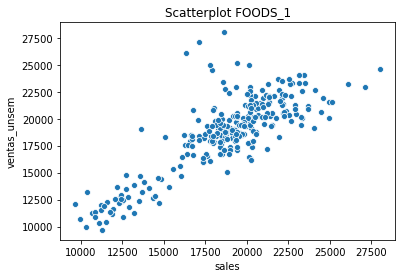

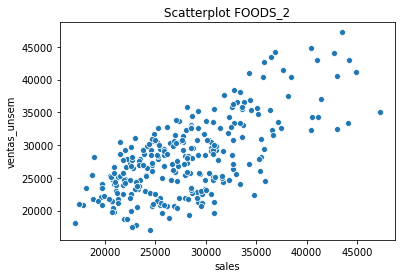

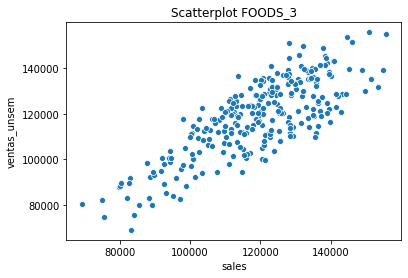

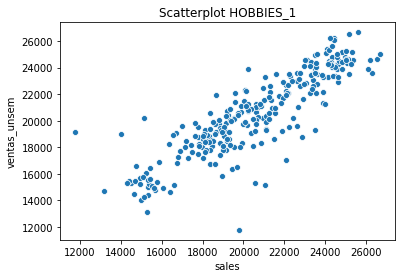

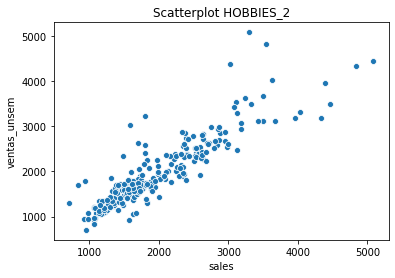

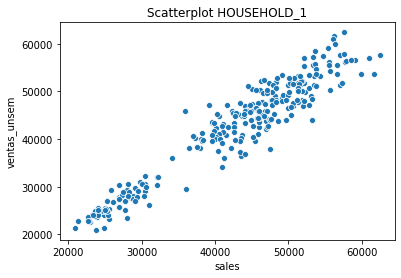

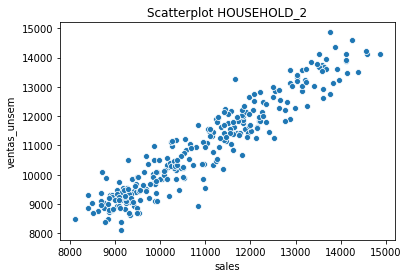

      year_final  semana      dept_id  sales         time  ventas_unsem  \
7           2011     5.0      FOODS_1  12625  2011.076923           NaN   
14          2011     6.0      FOODS_1  14378  2011.096154       12625.0   
21          2011     7.0      FOODS_1  14809  2011.115385       14378.0   
28          2011     8.0      FOODS_1  12733  2011.134615       14809.0   
35          2011     9.0      FOODS_1  12340  2011.153846       12733.0   
...          ...     ...          ...    ...          ...           ...   
1882        2016    12.0  HOUSEHOLD_2  14134  2016.211538       13477.0   
1889        2016    13.0  HOUSEHOLD_2  14109  2016.230769       14134.0   
1896        2016    14.0  HOUSEHOLD_2  14596  2016.250000       14109.0   
1903        2016    15.0  HOUSEHOLD_2  14243  2016.269231       14596.0   
1910        2016    16.0  HOUSEHOLD_2  14559  2016.288462       14243.0   

      ventas_dossem  
7               NaN  
14              NaN  
21          12625.0  
28         

In [10]:
dep_semana=agrupado_semana.sort_values(["dept_id","year_final","semana"])
dep_semana["ventas_unsem"]= dep_semana.groupby("dept_id")["sales"].shift(1)
dep_semana["ventas_dossem"]= dep_semana.groupby("dept_id")["sales"].shift(2)
departamento= dep_semana["dept_id"].unique()

for dep in departamento:
    sns.scatterplot(x="sales",y="ventas_unsem",data=dep_semana[dep_semana["dept_id"]==dep]).set_title("Scatterplot "+ dep)
    plt.show()

print(dep_semana)

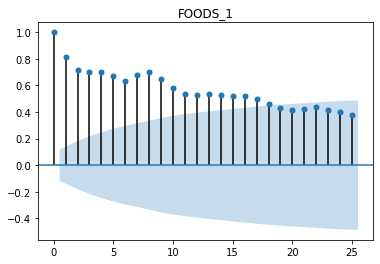

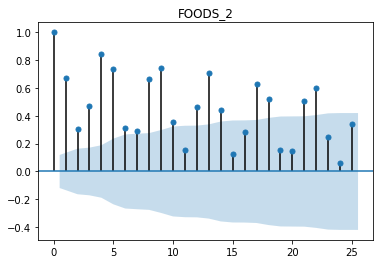

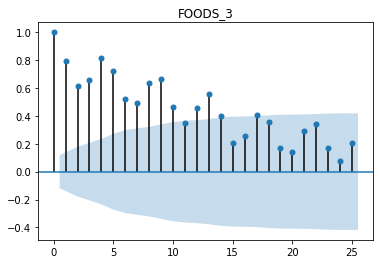

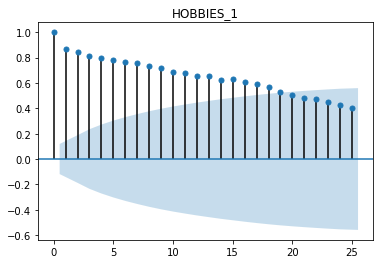

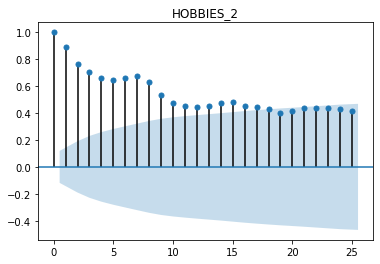

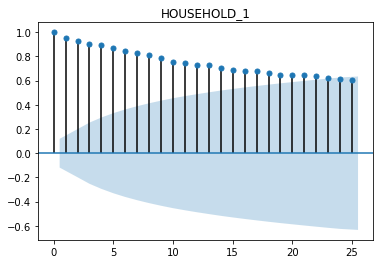

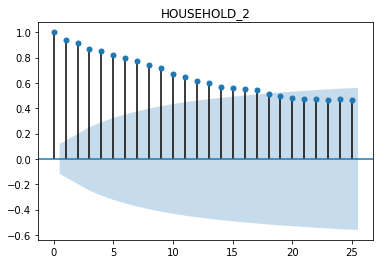

In [11]:
for dep in departamento:
    
    vents=dep_semana[dep_semana["dept_id"]==dep]["sales"]
    tsa.plot_acf(vents)
    plt.title(dep)
    vents

In [12]:
dep_semana=agrupado_semana.sort_values(["dept_id","year_final","semana"])
semana_venta=dep_semana

for lag in range(1,13):
    semana_venta["sales_"+str(lag)]= dep_semana.groupby(["dept_id"])["sales"].shift(lag)
    
print(dep_semana)

      year_final  semana      dept_id  sales         time  sales_1  sales_2  \
7           2011     5.0      FOODS_1  12625  2011.076923      NaN      NaN   
14          2011     6.0      FOODS_1  14378  2011.096154  12625.0      NaN   
21          2011     7.0      FOODS_1  14809  2011.115385  14378.0  12625.0   
28          2011     8.0      FOODS_1  12733  2011.134615  14809.0  14378.0   
35          2011     9.0      FOODS_1  12340  2011.153846  12733.0  14809.0   
...          ...     ...          ...    ...          ...      ...      ...   
1882        2016    12.0  HOUSEHOLD_2  14134  2016.211538  13477.0  13774.0   
1889        2016    13.0  HOUSEHOLD_2  14109  2016.230769  14134.0  13477.0   
1896        2016    14.0  HOUSEHOLD_2  14596  2016.250000  14109.0  14134.0   
1903        2016    15.0  HOUSEHOLD_2  14243  2016.269231  14596.0  14109.0   
1910        2016    16.0  HOUSEHOLD_2  14559  2016.288462  14243.0  14596.0   

      sales_3  sales_4  sales_5  sales_6  sales_7  

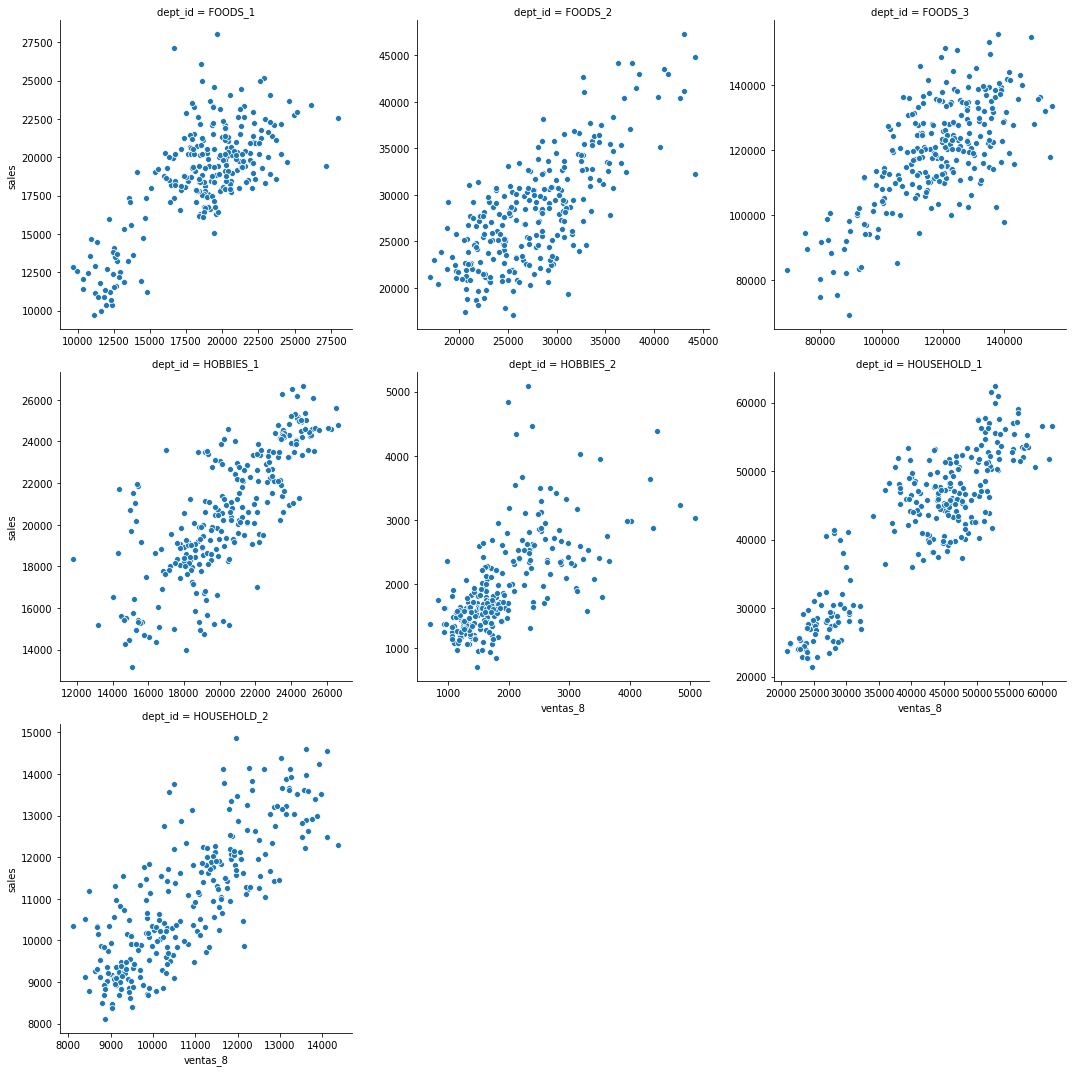

In [13]:
def plot_autocorr(lag):
    dep_semana=agrupado_semana.sort_values(["dept_id","year_final","semana"])
    
    dep_semana["ventas_"+str(lag)]=dep_semana.groupby("dept_id")["sales"].shift(lag)
    
    sns.relplot(x="ventas_"+str(lag),y="sales",col="dept_id",col_wrap= 3,data=dep_semana, facet_kws={"sharex":False,"sharey":False})

    
    plt.show()
    
plot_autocorr(8)


# El precio promedio de los productos, el precio promedio hace un mes/semana, el precio promedio de hace dos meses/semanas, etc.

In [14]:
#print(calendario_nuevo)
#print(precio_venta)
#print(cat_art)

precio_sem= calendario_nuevo[["dia","mes","semana","wm_yr_wk","year"]].merge(precio_venta,on="wm_yr_wk")
precio_sem= precio_sem.merge(cat_art[["item_id","dept_id"]],on="item_id")
precio_sem=precio_sem.groupby(["year","semana","dept_id"])["sell_price"].mean().reset_index()
precio_sem["time"]=precio_sem["year"]+(precio_sem["semana"]-1)/52

print(precio_sem[(precio_sem["year"]==2016)&(precio_sem["semana"]==17.0)])
precio_sem


      year  semana      dept_id  sell_price         time
1911  2016    17.0      FOODS_1    3.410078  2016.307692
1912  2016    17.0      FOODS_2    4.193589  2016.307692
1913  2016    17.0      FOODS_3    2.913829  2016.307692
1914  2016    17.0    HOBBIES_1    6.610077  2016.307692
1915  2016    17.0    HOBBIES_2    2.577159  2016.307692
1916  2016    17.0  HOUSEHOLD_1    5.175543  2016.307692
1917  2016    17.0  HOUSEHOLD_2    5.779873  2016.307692


,year,semana,dept_id,sell_price,time
0,2011,4.0,FOODS_1,3.030963,2011.057692
1,2011,4.0,FOODS_2,3.563718,2011.057692
2,2011,4.0,FOODS_3,2.676255,2011.057692
3,2011,4.0,HOBBIES_1,5.033308,2011.057692
4,2011,4.0,HOBBIES_2,2.767196,2011.057692
...,...,...,...,...,...
1976,2016,52.0,FOODS_3,2.911706,2016.980769
1977,2016,52.0,HOBBIES_1,6.619137,2016.980769
1978,2016,52.0,HOBBIES_2,2.577255,2016.980769
1979,2016,52.0,HOUSEHOLD_1,5.178238,2016.980769


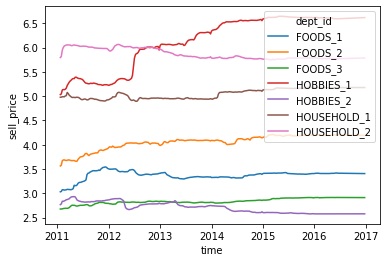

In [15]:


sns.lineplot(x="time",y="sell_price",hue="dept_id",data=precio_sem)

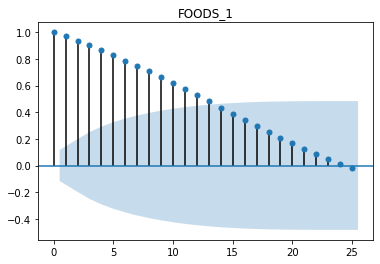

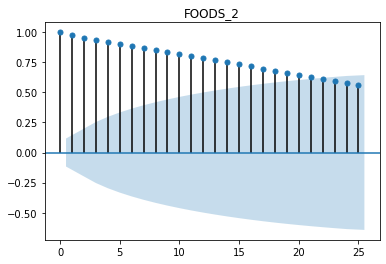

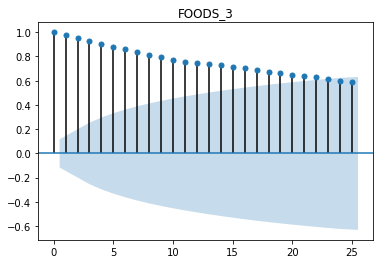

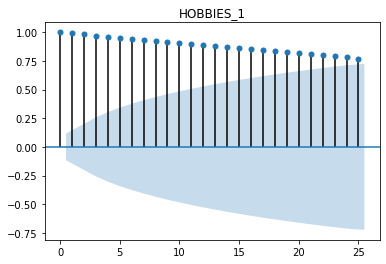

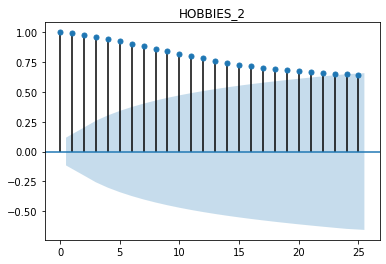

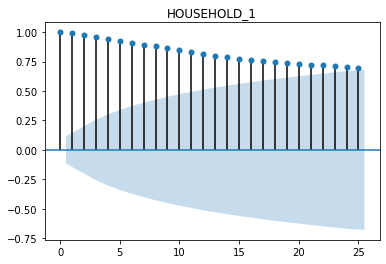

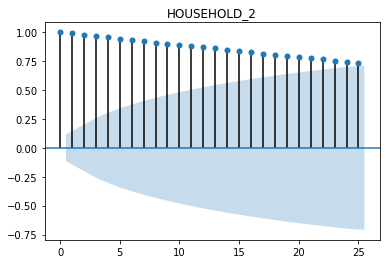

In [16]:
for dep in departamento:
    
    vents=precio_sem[precio_sem["dept_id"]==dep]["sell_price"]
    tsa.plot_acf(vents)
    plt.title(dep)
    vents

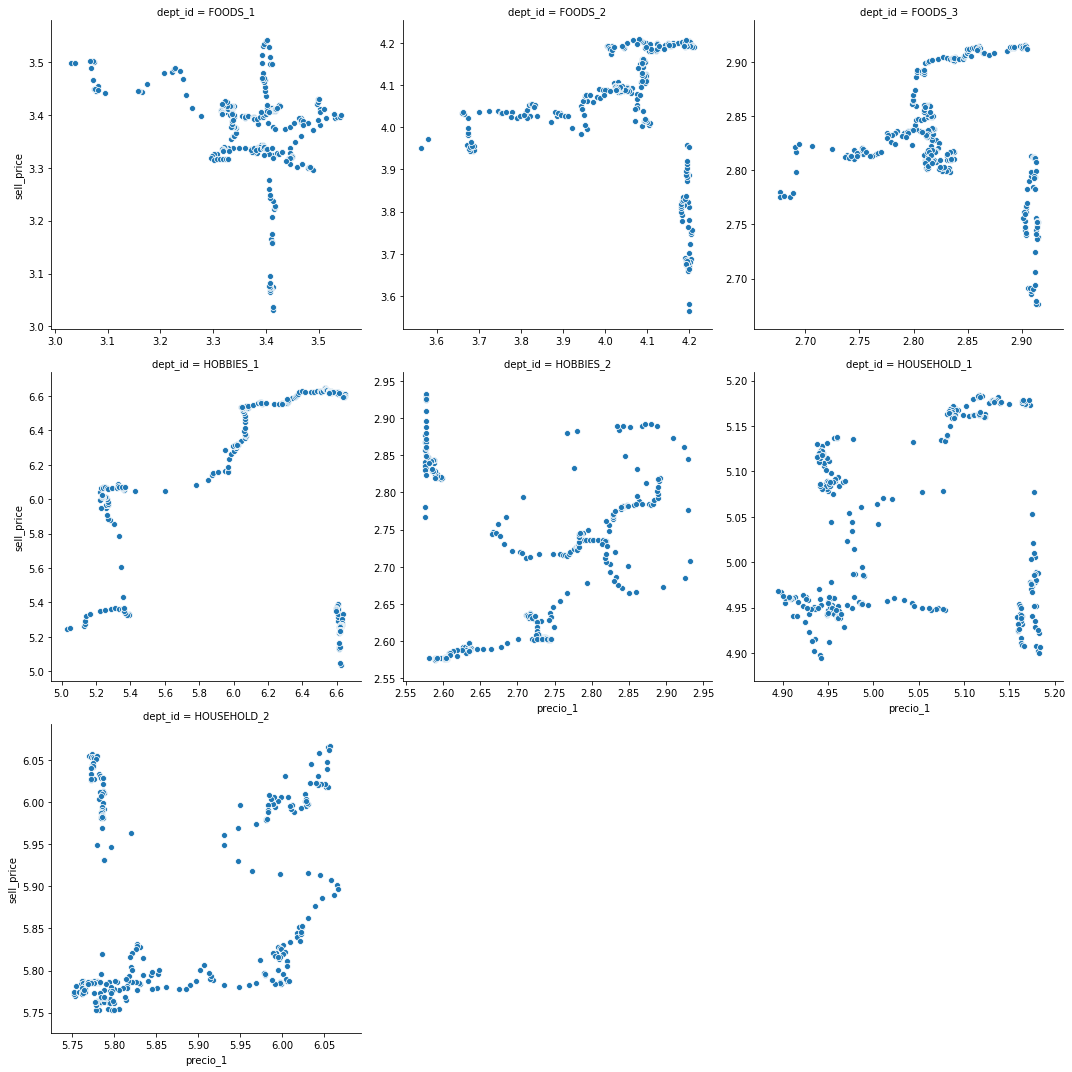

In [17]:
def plot_autocorr(lag):
    
    tabla=precio_sem.sort_values(["dept_id","semana"])
    
    tabla["precio_"+str(lag)]=tabla.groupby("dept_id")["sell_price"].shift(lag)
    
    sns.relplot(x="precio_"+str(lag),y="sell_price",col="dept_id",col_wrap= 3,data=tabla, facet_kws={"sharex":False,"sharey":False})

    
    plt.show()
    
plot_autocorr(1)

# el precio no es relevante como tal para el pronostico, su autocorrelacion no es importante.

# Como variables categóricas, el mes del año o la semana del año (por ejemplo si la venta es de la semana 3 de las 52 semanas del año).

In [18]:

dep_sem_datos= semana_venta.merge(precio_sem,right_on=["semana","time","dept_id","year"],left_on=["semana","time","dept_id","year_final"]).drop("year_final",axis=1)
columnas_sem= pd.get_dummies(dep_sem_datos["semana"])

dep_sem_datos=pd.concat([dep_sem_datos,columnas_sem],axis=1)
dep_sem_datos["sales_52"]=dep_sem_datos["sales"].shift(52)
print(dep_sem_datos)

      semana      dept_id  sales         time  sales_1  sales_2  sales_3  \
0        5.0      FOODS_1  12625  2011.076923      NaN      NaN      NaN   
1        6.0      FOODS_1  14378  2011.096154  12625.0      NaN      NaN   
2        7.0      FOODS_1  14809  2011.115385  14378.0  12625.0      NaN   
3        8.0      FOODS_1  12733  2011.134615  14809.0  14378.0  12625.0   
4        9.0      FOODS_1  12340  2011.153846  12733.0  14809.0  14378.0   
...      ...          ...    ...          ...      ...      ...      ...   
1899    12.0  HOUSEHOLD_2  14134  2016.211538  13477.0  13774.0  14867.0   
1900    13.0  HOUSEHOLD_2  14109  2016.230769  14134.0  13477.0  13774.0   
1901    14.0  HOUSEHOLD_2  14596  2016.250000  14109.0  14134.0  13477.0   
1902    15.0  HOUSEHOLD_2  14243  2016.269231  14596.0  14109.0  14134.0   
1903    16.0  HOUSEHOLD_2  14559  2016.288462  14243.0  14596.0  14109.0   

      sales_4  sales_5  sales_6  ...  44.0  45.0  46.0  47.0  48.0  49.0  \
0         N

# Define límites de fechas para determinar el conjunto de entrenamiento, el conjunto de validación, y el conjunto de prueba de los datos. [Preferiblemente seguir una proporción similar al 70%:15%:15%

In [19]:
lista_sem_año=dep_sem_datos[["year","semana","time"]].drop_duplicates()
lista_sem_año["conteo"]= lista_sem_año.index+1
lista_sem_año["conteo_acum"]= (lista_sem_año["conteo"]/272)
lista_sem_año["conjunto"]= np.where(lista_sem_año["conteo_acum"]<=.7,"entrenamiento",np.where(lista_sem_año["conteo_acum"]<=.85, "validacion","prueba"))

lista_time= lista_sem_año[lista_sem_año["time"]>=2012.42]

lista_entrenamiento= lista_time[lista_sem_año["conjunto"]=="entrenamiento"]
lista_entrenamiento=lista_entrenamiento.merge(dep_sem_datos,on=["year","semana","time"])

lista_validacion= lista_time[lista_sem_año["conjunto"]=="validacion"]
lista_validacion=lista_validacion.merge(dep_sem_datos,on=["year","semana","time"])

lista_prueba= lista_time[lista_sem_año["conjunto"]=="prueba"]
lista_prueba=lista_prueba.merge(dep_sem_datos,on=["year","semana","time"])
print(lista_entrenamiento)

     year  semana         time  conteo  conteo_acum       conjunto  \
0    2012    23.0  2012.423077      71     0.261029  entrenamiento   
1    2012    23.0  2012.423077      71     0.261029  entrenamiento   
2    2012    23.0  2012.423077      71     0.261029  entrenamiento   
3    2012    23.0  2012.423077      71     0.261029  entrenamiento   
4    2012    23.0  2012.423077      71     0.261029  entrenamiento   
..    ...     ...          ...     ...          ...            ...   
835  2014    38.0  2014.711538     190     0.698529  entrenamiento   
836  2014    38.0  2014.711538     190     0.698529  entrenamiento   
837  2014    38.0  2014.711538     190     0.698529  entrenamiento   
838  2014    38.0  2014.711538     190     0.698529  entrenamiento   
839  2014    38.0  2014.711538     190     0.698529  entrenamiento   

         dept_id   sales   sales_1   sales_2  ...  44.0  45.0  46.0  47.0  \
0        FOODS_1   19343   19721.0   18485.0  ...     0     0     0     0   
1    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# Entrenar el modelo con los datos de entrenamiento y generar proyecciones para el conjunto de validación

# Modelos ingenuos: Venta anterior; Promedio; Estacionalidad anterior.

In [20]:

entrenamiento_foods3=lista_entrenamiento[lista_entrenamiento["dept_id"]=="FOODS_3"]
validacion_foods3=lista_validacion[lista_validacion["dept_id"]=="FOODS_3"]
prueba_foods3=lista_prueba[lista_prueba["dept_id"]=="FOODS_3"]
#print(validacion_foods3)
error_ultimo= abs(validacion_foods3["sales"]-validacion_foods3["sales_1"])/validacion_foods3["sales"]
error_ultimo=error_ultimo.mean()

pronostico_ventapromedio=entrenamiento_foods3["sales"].mean()
error_pronostico= abs(validacion_foods3["sales"]-pronostico_ventapromedio)/validacion_foods3["sales"]
error_pronostico=error_pronostico.mean()


error_ultimo_52= abs(validacion_foods3["sales"]-validacion_foods3["sales_52"])/validacion_foods3["sales"]
error_ultimo_52=error_ultimo_52.mean()
print(error_ultimo_52)
print(error_ultimo)
print(error_pronostico)
#print(validacion_foods3)




0.09710549017802562
0.08143302646120013
0.10289071849524208


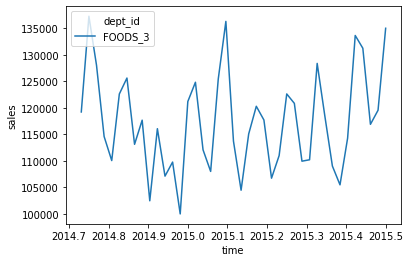

In [21]:
sns.lineplot(x="time",y="sales",hue="dept_id",data=validacion_foods3)

In [22]:
pron_simple=SimpleExpSmoothing(entrenamiento_foods3["sales"])
fit=pron_simple.fit()
prediccion= fit.forecast(41)
print(prediccion)
error= abs(validacion_foods3["sales"]-prediccion)/validacion_foods3["sales"]
error=error.mean()
error

120    130183.801734
121    130183.801734
122    130183.801734
123    130183.801734
124    130183.801734
125    130183.801734
126    130183.801734
127    130183.801734
128    130183.801734
129    130183.801734
130    130183.801734
131    130183.801734
132    130183.801734
133    130183.801734
134    130183.801734
135    130183.801734
136    130183.801734
137    130183.801734
138    130183.801734
139    130183.801734
140    130183.801734
141    130183.801734
142    130183.801734
143    130183.801734
144    130183.801734
145    130183.801734
146    130183.801734
147    130183.801734
148    130183.801734
149    130183.801734
150    130183.801734
151    130183.801734
152    130183.801734
153    130183.801734
154    130183.801734
155    130183.801734
156    130183.801734
157    130183.801734
158    130183.801734
159    130183.801734
160    130183.801734
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


0.1352033243147662

In [23]:
pron_doble=Holt(entrenamiento_foods3["sales"])
fit=pron_doble.fit()
prediccion= fit.forecast(41)
print(prediccion)
error= abs(validacion_foods3["sales"]-prediccion)/validacion_foods3["sales"]
error=error.mean()
print(error)

120    130182.617222
121    130182.622716
122    130182.628211
123    130182.633705
124    130182.639199
125    130182.644693
126    130182.650188
127    130182.655682
128    130182.661176
129    130182.666670
130    130182.672164
131    130182.677659
132    130182.683153
133    130182.688647
134    130182.694141
135    130182.699635
136    130182.705130
137    130182.710624
138    130182.716118
139    130182.721612
140    130182.727106
141    130182.732601
142    130182.738095
143    130182.743589
144    130182.749083
145    130182.754577
146    130182.760072
147    130182.765566
148    130182.771060
149    130182.776554
150    130182.782048
151    130182.787543
152    130182.793037
153    130182.798531
154    130182.804025
155    130182.809519
156    130182.815014
157    130182.820508
158    130182.826002
159    130182.831496
160    130182.836990
dtype: float64
0.13519671234427796


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [24]:
pron_triple=ExponentialSmoothing(entrenamiento_foods3["sales"],seasonal_periods=52)
fit=pron_triple.fit(smoothing_seasonal=0.6)
prediccion= fit.forecast(41)
print(prediccion)
error= abs(validacion_foods3["sales"]-prediccion)/validacion_foods3["sales"]
error=error.mean()
print(error)

120    130183.801734
121    130183.801734
122    130183.801734
123    130183.801734
124    130183.801734
125    130183.801734
126    130183.801734
127    130183.801734
128    130183.801734
129    130183.801734
130    130183.801734
131    130183.801734
132    130183.801734
133    130183.801734
134    130183.801734
135    130183.801734
136    130183.801734
137    130183.801734
138    130183.801734
139    130183.801734
140    130183.801734
141    130183.801734
142    130183.801734
143    130183.801734
144    130183.801734
145    130183.801734
146    130183.801734
147    130183.801734
148    130183.801734
149    130183.801734
150    130183.801734
151    130183.801734
152    130183.801734
153    130183.801734
154    130183.801734
155    130183.801734
156    130183.801734
157    130183.801734
158    130183.801734
159    130183.801734
160    130183.801734
dtype: float64
0.1352033243147662


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [25]:
lista_nueva=entrenamiento_foods3[entrenamiento_foods3["sales"]>=140000]
print(lista_nueva)

     year  semana         time  conteo  conteo_acum       conjunto  dept_id  \
2    2012    23.0  2012.423077      71     0.261029  entrenamiento  FOODS_3   
9    2012    24.0  2012.442308      72     0.264706  entrenamiento  FOODS_3   
30   2012    27.0  2012.500000      75     0.275735  entrenamiento  FOODS_3   
394  2013    27.0  2013.500000     127     0.466912  entrenamiento  FOODS_3   
429  2013    32.0  2013.596154     132     0.485294  entrenamiento  FOODS_3   
450  2013    35.0  2013.653846     135     0.496324  entrenamiento  FOODS_3   
457  2013    36.0  2013.673077     136     0.500000  entrenamiento  FOODS_3   
464  2013    37.0  2013.692308     137     0.503676  entrenamiento  FOODS_3   
485  2013    40.0  2013.750000     140     0.514706  entrenamiento  FOODS_3   
492  2013    41.0  2013.769231     141     0.518382  entrenamiento  FOODS_3   
667  2014    14.0  2014.250000     166     0.610294  entrenamiento  FOODS_3   
674  2014    15.0  2014.269231     167     0.613971 

In [26]:
modelo_arima= pmd.auto_arima(entrenamiento_foods3["sales"], m=52, stepwise=False, n_jobs=-1,trace=True)
prediccion_arima=modelo_arima.predict(41)
print(modelo_arima)

Total fit time: 92.614 seconds
ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 52),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)


In [27]:
print(prediccion_arima)
error= abs(validacion_foods3["sales"]-prediccion_arima)/validacion_foods3["sales"]
error=error.mean()
print(error)

[124228.63642924 136475.2129838  135023.40863523 122079.60107126
 120123.35621043 132349.24995933 137043.81408572 125780.81452117
 118235.07508793 127561.23661395 137251.11255732 130176.95730161
 118718.2699225  122975.81423679 135408.71109099 134104.54024562
 121327.50161265 119528.65574428 131846.64102849 136590.30899624
 125400.79711169 117951.89689258 127334.87280492 137030.84441793
 129975.79563155 118577.70840361 122882.53400931 135309.43318707
 133992.59263379 121248.56784889 119495.414868   131812.31259769
 136527.48907743 125346.76579253 117940.60952598 127335.21620294
 136999.70347826 129932.49851919 118568.84273306 122899.01316951
 135301.68034497]
0.09211253435794527


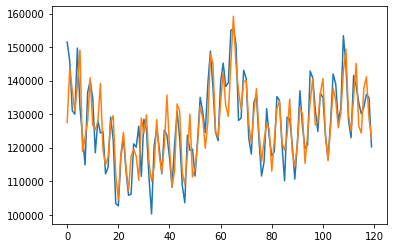

In [28]:

plt.plot(entrenamiento_foods3["sales"].values)
plt.plot(modelo_arima.predict_in_sample())


     year  semana         time  sell_price  1.0  2.0  3.0  4.0  5.0  6.0  ...  \
2    2014    39.0  2014.730769    2.847400    0    0    0    0    0    0  ...   
9    2014    40.0  2014.750000    2.849183    0    0    0    0    0    0  ...   
16   2014    41.0  2014.769231    2.849232    0    0    0    0    0    0  ...   
23   2014    42.0  2014.788462    2.849276    0    0    0    0    0    0  ...   
30   2014    43.0  2014.807692    2.850332    0    0    0    0    0    0  ...   
37   2014    44.0  2014.826923    2.849736    0    0    0    0    0    0  ...   
44   2014    45.0  2014.846154    2.851612    0    0    0    0    0    0  ...   
51   2014    46.0  2014.865385    2.854107    0    0    0    0    0    0  ...   
58   2014    47.0  2014.884615    2.855831    0    0    0    0    0    0  ...   
65   2014    48.0  2014.903846    2.858200    0    0    0    0    0    0  ...   
72   2014    49.0  2014.923077    2.859958    0    0    0    0    0    0  ...   
79   2014    50.0  2014.9423

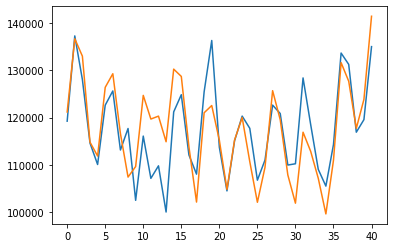

In [29]:
food=entrenamiento_foods3.drop(["conteo","conteo_acum","sales_52","sales","conjunto","dept_id",'sales_1','sales_2','sales_3','sales_4','sales_5','sales_6','sales_7','sales_8','sales_9','sales_10','sales_11','sales_12'],axis=1)
foods_val=validacion_foods3.drop(["conteo","conteo_acum","sales_52","sales","conjunto","dept_id",'sales_1','sales_2','sales_3','sales_4','sales_5','sales_6','sales_7','sales_8','sales_9','sales_10','sales_11','sales_12'],axis=1)
regresor=linear_model.LinearRegression()
x=food
x_vali=foods_val
y=entrenamiento_foods3["sales"].values.reshape(-1,1)


regresor.fit(x,y)
prediccion_valid=regresor.predict(x_vali).flatten()
prediccion=regresor.predict(x).flatten()
plt.plot(validacion_foods3["sales"].values)
plt.plot(prediccion_valid)

error=abs(validacion_foods3["sales"]-prediccion_valid)/validacion_foods3["sales"]
error=error.mean()
print(x_vali)
print(error)

[125604.49992392 125604.49992197 125604.49991898 125604.499916
 125604.49991353 125604.49991157 125604.4999091  125604.49990611
 125604.49990364 125604.49990116 125604.4998992  125604.49989621
 125604.49989424 125604.49989125 125604.50002789 125604.50002494
 125604.50002199 125604.50001955 125604.50001762 125604.50001569
 125604.50001222 125604.50000977 125604.50000733 125604.50000539
 125604.50000295 125604.49999999 125604.49999754 125604.49999611
 125604.49999315 125604.4999907  125604.49998774 125604.4999858
 125604.49998334 125604.49998038 125604.49997792 125604.49997598
 125604.49997429 125604.49997183 125604.49996886 125604.49996691
 125604.49996445]
0.09448031685744661


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


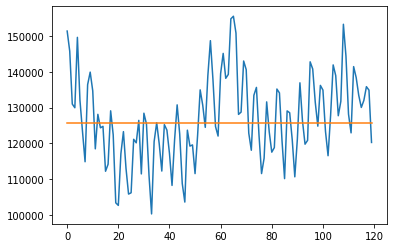

In [30]:
modelo_1=SVR(kernel="rbf",epsilon=.0001,C=1)
food=entrenamiento_foods3.drop(["conteo","conteo_acum","sales_52","sales","conjunto","dept_id",'sales_1','sales_2','sales_3','sales_4','sales_5','sales_6','sales_7','sales_8','sales_9','sales_10','sales_11','sales_12'],axis=1)
foods_val=validacion_foods3.drop(["conteo","conteo_acum","sales_52","sales","conjunto","dept_id",'sales_1','sales_2','sales_3','sales_4','sales_5','sales_6','sales_7','sales_8','sales_9','sales_10','sales_11','sales_12'],axis=1)
x=food
x_vali=foods_val
y=entrenamiento_foods3["sales"].values.reshape(-1,1)
modelo_1.fit(x,y)
prediccion=modelo_1.predict(x).flatten()
prediccion_valid=modelo_1.predict(x_vali).flatten()
print(prediccion_valid)

plt.plot(entrenamiento_foods3["sales"].values)
plt.plot(prediccion)

error=abs(validacion_foods3["sales"]-prediccion_valid)/validacion_foods3["sales"]
error=error.mean()

print(error)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


[126685.89 128509.69 127979.07 123368.05 121981.07 124122.32 124087.41
 121228.58 118259.25 119137.59 122541.38 120563.42 120487.01 119945.94
 130346.49 130037.58 127854.36 122845.1  128685.58 128986.48 128109.5
 124006.51 128152.56 130198.41 128300.04 126511.01 127832.39 134301.88
 131439.82 128548.3  127363.56 129954.97 129652.1  126076.06 121766.25
 127990.84 133469.3  132383.78 129262.52 131040.13 145243.51]
0.09272798873510656
Index([      'year',     'semana',       'time', 'sell_price',          1.0,
                2.0,          3.0,          4.0,          5.0,          6.0,
                7.0,          8.0,          9.0,         10.0,         11.0,
               12.0,         13.0,         14.0,         15.0,         16.0,
               17.0,         18.0,         19.0,         20.0,         21.0,
               22.0,         23.0,         24.0,         25.0,         26.0,
               27.0,         28.0,         29.0,         30.0,         31.0,
               32.0,     

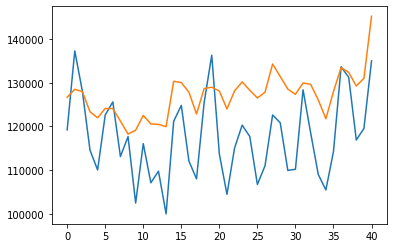

In [31]:
modelo_1=RandomForestRegressor()
food=entrenamiento_foods3.drop(["conteo","conteo_acum","sales_52","sales","conjunto","dept_id",'sales_1','sales_2','sales_3','sales_4','sales_5','sales_6','sales_7','sales_8','sales_9','sales_10','sales_11','sales_12'],axis=1)
foods_val=validacion_foods3.drop(["conteo","conteo_acum","sales_52","sales","conjunto","dept_id",'sales_1','sales_2','sales_3','sales_4','sales_5','sales_6','sales_7','sales_8','sales_9','sales_10','sales_11','sales_12'],axis=1)
x=food
x_vali=foods_val
y=entrenamiento_foods3["sales"].values.reshape(-1,1)
modelo_1.fit(x,y)
prediccion=modelo_1.predict(x).flatten()
prediccion_valid=modelo_1.predict(x_vali).flatten()
print(prediccion_valid)

plt.plot(validacion_foods3["sales"].values)
plt.plot(prediccion_valid)

error=abs(validacion_foods3["sales"]-prediccion_valid)/validacion_foods3["sales"]
error=error.mean()

print(error)
print(food.columns)

In [32]:
lista_z=lista_time.merge(dep_sem_datos,on=["year","semana","time"])
lista_z=lista_z.drop(['sales_1',"sales_52","conteo_acum","conteo",  'sales_2',     'sales_3',     'sales_4','sales_5',     'sales_6',     'sales_7',     'sales_8','sales_9',    'sales_10',    'sales_11',    'sales_12'],axis=1)
todas_var=lista_z
#z_entrenamiento=lista_z[lista_z["conjunto"]=="entrenamiento"].drop("conjunto",axis=1)
#z_validacion=lista_z[lista_z["conjunto"]=="validacion"].drop("conjunto",axis=1)
#z_prueba=lista_z[lista_z["conjunto"]=="prueba"].drop("conjunto",axis=1)
print(lista_z)




      year  semana         time       conjunto      dept_id   sales  \
0     2012    23.0  2012.423077  entrenamiento      FOODS_1   19343   
1     2012    23.0  2012.423077  entrenamiento      FOODS_2   28671   
2     2012    23.0  2012.423077  entrenamiento      FOODS_3  151465   
3     2012    23.0  2012.423077  entrenamiento    HOBBIES_1   19834   
4     2012    23.0  2012.423077  entrenamiento    HOBBIES_2    1269   
...    ...     ...          ...            ...          ...     ...   
1409  2016    16.0  2016.288462         prueba      FOODS_3  134477   
1410  2016    16.0  2016.288462         prueba    HOBBIES_1   25013   
1411  2016    16.0  2016.288462         prueba    HOBBIES_2    2614   
1412  2016    16.0  2016.288462         prueba  HOUSEHOLD_1   53762   
1413  2016    16.0  2016.288462         prueba  HOUSEHOLD_2   14559   

      sell_price  1.0  2.0  3.0  ...  43.0  44.0  45.0  46.0  47.0  48.0  \
0       3.481240    0    0    0  ...     0     0     0     0     0     

In [33]:

listaz_final=pd.DataFrame()
departamento= lista_z["dept_id"].unique()

for dept in departamento:
    lista_cache=lista_z[lista_z["dept_id"]==dept]
    lista_cache["year"]=(lista_cache["year"]-np.mean(lista_cache["year"]))/np.std(lista_cache["year"])
    lista_cache["semana"]=(lista_cache["semana"]-np.mean(lista_cache["semana"]))/np.std(lista_cache["semana"])
    lista_cache["time"]=(lista_cache["time"]-np.mean(lista_cache["time"]))/np.std(lista_cache["time"])
    lista_cache["sell_price"]=(lista_cache["sell_price"]-np.mean(lista_cache["sell_price"]))/np.std(lista_cache["sell_price"])
    listaz_final=listaz_final.append(lista_cache)
    
z_entrenamiento=listaz_final[listaz_final["conjunto"]=="entrenamiento"].drop("conjunto",axis=1)
z_validacion=listaz_final[listaz_final["conjunto"]=="validacion"].drop("conjunto",axis=1)
z_prueba=listaz_final[listaz_final["conjunto"]=="prueba"].drop("conjunto",axis=1)

foodz_prueba= z_prueba[z_prueba["dept_id"]=="FOODS_3"].drop("dept_id",axis=1)
foodz_validacion= z_validacion[z_validacion["dept_id"]=="FOODS_3"].drop("dept_id",axis=1)
foodz_entrenamiento=z_entrenamiento[z_entrenamiento["dept_id"]=="FOODS_3"].drop("dept_id",axis=1)
x_valid=foodz_validacion.drop("sales",axis=1)
y_valid=foodz_validacion["sales"]
x=foodz_entrenamiento.drop("sales",axis=1)
y=foodz_entrenamiento["sales"]
print(lista_cache)

          year    semana      time       conjunto      dept_id  sales  \
6    -1.569503 -0.244304 -1.723497  entrenamiento  HOUSEHOLD_2  10255   
13   -1.569503 -0.178417 -1.706348  entrenamiento  HOUSEHOLD_2  10176   
20   -1.569503 -0.112530 -1.689199  entrenamiento  HOUSEHOLD_2  10343   
27   -1.569503 -0.046643 -1.672050  entrenamiento  HOUSEHOLD_2  10319   
34   -1.569503  0.019244 -1.654901  entrenamiento  HOUSEHOLD_2  10156   
...        ...       ...       ...            ...          ...    ...   
1385  1.803259 -0.969063  1.654901         prueba  HOUSEHOLD_2  14134   
1392  1.803259 -0.903176  1.672050         prueba  HOUSEHOLD_2  14109   
1399  1.803259 -0.837289  1.689199         prueba  HOUSEHOLD_2  14596   
1406  1.803259 -0.771402  1.706348         prueba  HOUSEHOLD_2  14243   
1413  1.803259 -0.705515  1.723497         prueba  HOUSEHOLD_2  14559   

      sell_price  1.0  2.0  3.0  ...  43.0  44.0  45.0  46.0  47.0  48.0  \
6       2.416410    0    0    0  ...     0     

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [34]:
modelo_1=SVR(kernel="rbf",epsilon=200000,C=1)
modelo_1.fit(x,y)
prediccion=modelo_1.predict(x).flatten()


print(prediccion)

[127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920. 127920.
 127920. 127920. 127920.]


#Validacion Cruzada

c=2.0**np.arange(-4,5)
epsilon=10.0**np.arange(1,7)
variable_d=40,80,120
df_svm=pd.DataFrame()

for costo in c:
    for ep in epsilon:
        prediccion=[]
        real=[]
        for renglones in variable_d:
            x= foodz_entrenamiento.drop("sales",axis=1).iloc[0:renglones]
            y= foodz_entrenamiento["sales"].iloc[0:renglones]
            x_prueba= foodz_entrenamiento.drop(x.index).iloc[0:40].drop("sales",axis=1)
            y_prueba= foodz_entrenamiento.drop(x.index).iloc[0:40]["sales"]
            model_cache= SVR(kernel="rbf",epsilon=ep,C=costo)
            
            if len (x_prueba)>0:
                model_cache.fit(x,y)
                y_prediccion= model_cache.predict(x_prueba).flatten()
                prediccion.extend(y_prediccion.tolist())
                real.extend(y_prueba.tolist())
                
        mape=np.mean(abs(np.array(prediccion)-np.array(real))/np.array(real))
        df_svm=df_svm.append(pd.Series({"epsilon":ep,"costo":costo,"MAPE":mape},name="A"))

In [35]:
#mejor_valor=A	0.071073	0.0625	100000.0

#Random Forest
features= [3,4,5]
ntris=np.arange(50,1001,50)
df_rf=pd.DataFrame()
for f in features:
    for n in ntris:
        prediccion=[]
        real=[]
        for renglones in variable_d:
            x= foodz_entrenamiento.drop("sales",axis=1).iloc[0:renglones]
            y= foodz_entrenamiento["sales"].iloc[0:renglones]
            x_prueba= foodz_entrenamiento.drop(x.index).iloc[0:40].drop("sales",axis=1)
            y_prueba= foodz_entrenamiento.drop(x.index).iloc[0:40]["sales"]
            model_cache= RandomForestRegressor(n_estimators=n, max_features=f,n_jobs=-1)
            
            if len (x_prueba)>0:
                model_cache.fit(x,y)
                
                cache=x_prueba.iloc[[0]]
                for i in range(len(x_prueba)):
                    y_prediccion= model_cache.predict(cache).item(0)
                    prediccion.append(y_prediccion)
                    nuevo_z=(y_prediccion-promedios["FOODS_3"])/desviacion["FOODS_3"]
                    cache.loc[:,["sales_2","sales_3","sales_4","sales_5"]]=cache.loc[:,["sales_1","sales_2","sales_3","sales_4"]].values[0]
                    cache["sales_1"]=nuevo_z
                    if len (x_prueba)>i+1:
                        cache.iloc[0,0:56]=x_prueba.iloc[i+1,0:56]
                real.extend(y_prueba.tolist())
                
        mape=np.mean(abs(np.array(prediccion)-np.array(real))/np.array(real))
        df_rf=df_rf.append(pd.Series({"features":f,"ntris":n,"MAPE":mape},name="A"))


print(foodz_entrenamiento)

In [45]:
features= [3,4,5]
ntris=np.arange(50,1001,50)
df_rf=pd.DataFrame()
variable_d=[40,80,120]
for f in features:
    for n in ntris:
        print("features: "+ str(f)+", ntris: "+ str(n))
        prediccion=[]
        real=[]
        for renglones in variable_d:
            x= foodz_entrenamiento.drop("sales",axis=1).iloc[0:renglones]
            y= foodz_entrenamiento["sales"].iloc[0:renglones]
            x_prueba= foodz_entrenamiento.drop(x.index).iloc[0:40].drop("sales",axis=1)
            y_prueba= foodz_entrenamiento.drop(x.index).iloc[0:40]["sales"]
            model_cache= RandomForestRegressor(n_estimators=n, max_features=f,n_jobs=-1)
            
            if len (x_prueba)>0:
                model_cache.fit(x,y)
                
                cache=x_prueba.iloc[[0]].copy()
                for i in range(len(x_prueba)):
                    y_prediccion= model_cache.predict(cache).item(0)
                    prediccion.append(y_prediccion)
                    nuevo_z=(y_prediccion-promedios["FOODS_3"])/desviacion["FOODS_3"]
                    cache.loc[:,["sales_2","sales_3","sales_4","sales_5"]]=cache.loc[:,["sales_1","sales_2","sales_3","sales_4"]].values[0]
                    cache["sales_1"]=nuevo_z
                    if len (x_prueba)>i+1:
                        cache.iloc[0,0:56]=x_prueba.iloc[i+1,0:56]
                real.extend(y_prueba.tolist())
                
        mape=np.mean(abs(np.array(prediccion)-np.array(real))/np.array(real))
        df_rf=df_rf.append(pd.Series({"features":f,"ntris":n,"MAPE":mape},name="A"))


print(foodz_entrenamiento)

features: 3, ntris: 50
features: 3, ntris: 100
features: 3, ntris: 150
features: 3, ntris: 200
features: 3, ntris: 250
features: 3, ntris: 300
features: 3, ntris: 350
features: 3, ntris: 400
features: 3, ntris: 450
features: 3, ntris: 500
features: 3, ntris: 550
features: 3, ntris: 600
features: 3, ntris: 650
features: 3, ntris: 700


KeyboardInterrupt: 

In [ ]:
df_rf[df_rf["MAPE"]==min(df_rf["MAPE"])]

In [ ]:
df_rf[df_rf["MAPE"]==min(df_rf["MAPE"])]
#MAPE	features	ntris
#A	0.065904	3.0	50.0

In [38]:
x=foodz_entrenamiento.drop("sales",axis=1)
y=foodz_entrenamiento["sales"]
x_valid=foodz_validacion.drop("sales",axis=1)
y_valid=foodz_validacion["sales"]

modelo_1=SVR(kernel="rbf",epsilon=100000,C=.0625)
modelo_1.fit(x,y)
prediccion=modelo_1.predict(x).flatten()

y_prediccion=modelo_1.predict(x_valid).flatten()
mape=np.mean(abs(np.array(y_valid)-np.array(y_prediccion))/np.array(y_valid))

print(mape)

0.10835277686912886


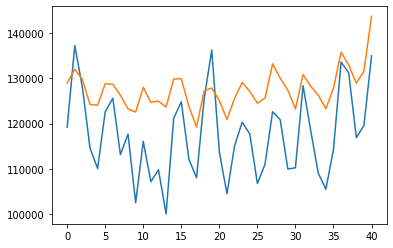

In [39]:
x=foodz_entrenamiento.drop("sales",axis=1)
y=foodz_entrenamiento["sales"]
x_valid=foodz_validacion.drop("sales",axis=1)
y_valid=foodz_validacion["sales"]
modelo_1=RandomForestRegressor(n_estimators=50, max_features=3,n_jobs=-1)
modelo_1.fit(x,y)
prediccion=modelo_1.predict(x_valid).flatten()
mape=np.mean(abs(np.array(y_valid)-np.array(prediccion))/np.array(y_valid))
#print(prediccion)

plt.plot(y_valid.values)
plt.plot(prediccion)

In [ ]:
#print(foodz_prueba)

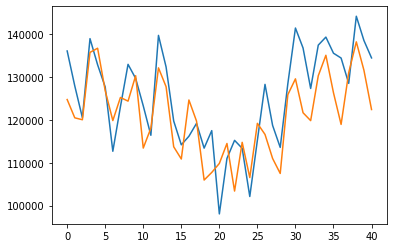

In [46]:
x_valid=foodz_validacion.drop("sales",axis=1)
x_entrenamiento=foodz_entrenamiento.drop("sales",axis=1)
y_valid=foodz_validacion["sales"]
y_entrenamiento=foodz_entrenamiento["sales"]
x_total=pd.concat([x_entrenamiento,x_valid],axis=0)
y_total=pd.concat([y_entrenamiento,y_valid],axis=0)
regresor_final=linear_model.LinearRegression()
regresor_final.fit(x_total,y_total)
x_prueba=foodz_prueba.drop("sales",axis=1)
y_prueba=foodz_prueba["sales"]
prediccion=regresor_final.predict(x_prueba).flatten()
mape=np.mean(abs(np.array(y_prueba)-np.array(prediccion))/np.array(y_prueba))
plt.plot(y_prueba.values)
plt.plot(prediccion)

In [47]:
print(prediccion)
print(mape)

[124752.89824621 120483.28771963 120033.42521294 135766.35760385
 136739.05610531 126818.81469731 119839.81159423 125238.7458253
 124380.55474868 130322.16825076 113419.01297314 118067.47299722
 132155.60451057 127751.07762066 113721.4898972  110860.76246132
 124648.41666485 119719.56656137 105949.38797263 107723.14226866
 109827.99085023 114488.49490232 103374.86537391 114755.14527503
 106528.92571831 119192.00497241 116604.04288777 110985.22014274
 107485.88855371 125886.11811626 129588.32546384 121668.49844094
 119828.72427431 130308.7410734  135093.8845893  126329.38179577
 118941.65437727 131028.12728779 138231.4219788  131607.05813794
 122422.15578906]
0.05214688921449009


In [73]:
x=pd.concat([x_total,x_prueba])
y=pd.concat([y_total,y_prueba])
modelo_final=linear_model.LinearRegression()
modelo_final.fit(x,y)

prediccion=regresor.predict(x).flatten()
data_2016=dep_semana[(dep_semana["year_final"]==2016)&(dep_semana["semana"]>0)
year=[2016 for i in range (52)]
semana=[i+1 for i in range (52)]
tiempo=np.array(year)+(np.array(semana)-1)/52
sell_price=[2.913829 for i in range (52)]
df_2016= pd.DataFrame({"year":year,"semana":semana,"time":tiempo,"sell_price":sell_price})
semana=pd.get_dummies(df_2016["semana"])

df_completo=pd.concat([df_2016,semana],axis=1)
df_completo=df_completo[df_completo["semana"]>=17.0]



mean_year= todas_var["year"].mean()
mean_semana= todas_var["semana"].mean()
mean_sales= todas_var["sales"].mean()
mean_sell_price= todas_var["sell_price"].mean()
std_year= todas_var["year"].std()
std_semana= todas_var["semana"].std()
std_sales= todas_var["sales"].std()
std_sell_price= todas_var["sell_price"].std()
x_normal=df_completo.copy()
x_normal["year"]=(x_normal["year"]-mean_year)/std_year
x_normal["semana"]=(x_normal["semana"]-mean_semana)/std_semana
x_normal["sell_price"]=(x_normal["sell_price"]-mean_sell_price)/std_sell_price
prediccion_final=modelo_final.predict(x_normal).flatten()

plt.plot(prediccion_final)

print(prediccion_final)

SyntaxError: invalid syntax (<ipython-input-73-86b1555c4f0e>, line 8)

In [49]:
todas_var=todas_var[todas_var["dept_id"]=="FOODS_3"]
x_valid





,year,semana,time,sell_price,1.0,2.0,3.0,4.0,5.0,6.0,...,48.0,49.0,50.0,51.0,52.0,sales_1,sales_2,sales_3,sales_4,sales_5
842,0.116878,0.809890,0.334410,-0.036200,0,0,0,0,0,0,...,0,0,0,0,0,-0.375708,0.856503,0.937407,0.614043,0.448454
849,0.116878,0.875778,0.351559,0.009054,0,0,0,0,0,0,...,0,0,0,0,0,-0.462073,-0.375708,0.856503,0.937407,0.614043
856,0.116878,0.941665,0.368708,0.010303,0,0,0,0,0,0,...,0,0,0,0,0,1.056705,-0.462073,-0.375708,0.856503,0.937407
863,0.116878,1.007552,0.385858,0.011419,0,0,0,0,0,0,...,0,0,0,0,0,0.279673,1.056705,-0.462073,-0.375708,0.856503
870,0.116878,1.073439,0.403007,0.038204,0,0,0,0,0,0,...,0,0,0,0,0,-0.851807,0.279673,1.056705,-0.462073,-0.375708
877,0.116878,1.139326,0.420156,0.023091,0,0,0,0,0,0,...,0,0,0,0,0,-1.233475,-0.851807,0.279673,1.056705,-0.462073
884,0.116878,1.205213,0.437305,0.070706,0,0,0,0,0,0,...,0,0,0,0,0,-0.176766,-1.233475,-0.851807,0.279673,1.056705
891,0.116878,1.271101,0.454455,0.134013,0,0,0,0,0,0,...,0,0,0,0,0,0.076195,-0.176766,-1.233475,-0.851807,0.279673
898,0.116878,1.336988,0.471604,0.177771,0,0,0,0,0,0,...,0,0,0,0,0,-0.975389,0.076195,-0.176766,-1.233475,-0.851807
905,0.116878,1.402875,0.488753,0.237869,0,0,0,0,0,0,...,1,0,0,0,0,-0.592376,-0.975389,0.076195,-0.176766,-1.233475


In [50]:
listaz_final=pd.DataFrame()
departamento= lista_z["dept_id"].unique()
promedios={}
desviacion={}


for dept in departamento:
    
    lista_cache=lista_z[lista_z["dept_id"]==dept]
    promedios_ventas=lista_cache["sales"].mean()
    promedio_std=lista_cache["sales"].std()
    lista_cache["year"]=(lista_cache["year"]-np.mean(lista_cache["year"]))/np.std(lista_cache["year"])
    lista_cache["semana"]=(lista_cache["semana"]-np.mean(lista_cache["semana"]))/np.std(lista_cache["semana"])
    lista_cache["time"]=(lista_cache["time"]-np.mean(lista_cache["time"]))/np.std(lista_cache["time"])
    lista_cache["sell_price"]=(lista_cache["sell_price"]-np.mean(lista_cache["sell_price"]))/np.std(lista_cache["sell_price"])
    
    for semana in range(5):
        lista_cache["sales_" + str(semana+1)]= (lista_cache[("sales")].shift(semana+1)-promedios_ventas)/promedio_std
        promedios[dept]=promedios_ventas
        desviacion[dept]=promedio_std
    
    
    
    listaz_final=listaz_final.append(lista_cache)
    
z_entrenamiento=listaz_final[listaz_final["conjunto"]=="entrenamiento"].drop("conjunto",axis=1)
z_validacion=listaz_final[listaz_final["conjunto"]=="validacion"].drop("conjunto",axis=1)
z_prueba=listaz_final[listaz_final["conjunto"]=="prueba"].drop("conjunto",axis=1)

foodz_prueba= z_prueba[z_prueba["dept_id"]=="FOODS_3"].drop("dept_id",axis=1)
foodz_validacion= z_validacion[z_validacion["dept_id"]=="FOODS_3"].drop("dept_id",axis=1)
foodz_entrenamiento=z_entrenamiento[z_entrenamiento["dept_id"]=="FOODS_3"].drop("dept_id",axis=1).dropna()
x_valid=foodz_validacion.drop("sales",axis=1)
y_valid=foodz_validacion["sales"]
x=foodz_entrenamiento.drop("sales",axis=1)
y=foodz_entrenamiento["sales"]
print(x)
print(desviacion)

         year    semana      time  sell_price  1.0  2.0  3.0  4.0  5.0  6.0  \
37  -1.569503  0.085131 -1.637751   -0.806885    0    0    0    0    0    0   
44  -1.569503  0.151019 -1.620602   -0.900078    0    0    0    0    0    0   
51  -1.569503  0.216906 -1.603453   -0.866266    0    0    0    0    0    0   
58  -1.569503  0.282793 -1.586304   -0.832085    0    0    0    0    0    0   
65  -1.569503  0.348680 -1.569154   -0.893993    0    0    0    0    0    0   
..        ...       ...       ...         ...  ...  ...  ...  ...  ...  ...   
807  0.116878  0.480455  0.248664   -0.280705    0    0    0    0    0    0   
814  0.116878  0.546342  0.265813   -0.183484    0    0    0    0    0    0   
821  0.116878  0.612229  0.282962   -0.068519    0    0    0    0    0    0   
828  0.116878  0.678116  0.300111   -0.043108    0    0    0    0    0    0   
835  0.116878  0.744003  0.317261   -0.051649    0    0    0    0    0    0   

     ...  48.0  49.0  50.0  51.0  52.0   sales_1   

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [42]:
modelo=linear_model.LinearRegression()
modelo.fit(x,y)
fit_train=modelo.predict(x)
#print("mse: "+ str(mean_squared_error(y,fit_train)))
#print("r**2: "+ str(r2_score(y,fit_train)))
cache = x_valid.iloc[[0]]
#print(cache)
forecast_valid=[]
for i in range(len(x_valid)):
    pronostico= modelo.predict(cache).item(0)
    forecast_valid.append(pronostico)
    nuevo_z= (pronostico-promedios["FOODS_3"])/desviacion["FOODS_3"]
    cache.loc[:,["sales_2","sales_3","sales_4","sales_5"]]=cache.loc[:,["sales_1","sales_2","sales_3","sales_4"]].values[0]
    cache["sales_1"]=nuevo_z
    if len(x_valid)>i+1:
       cache.iloc[0,0:56]=x_valid.iloc[i+1,0:56]
    #print(cache.iloc[:,0:4])
    
    

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

[121616.0, 137262.0, 133118.0, 115454.0, 112998.0, 128112.0, 131948.0, 119682.0, 110232.0, 112294.0, 127402.0, 122434.0, 122626.0, 116136.0, 132712.0, 130756.0, 116524.0, 105352.0, 124378.0, 126150.0, 118740.0, 108910.0, 119726.0, 125422.0, 115666.0, 106814.0, 113260.0, 128906.0, 123356.0, 111380.0, 105136.0, 120514.0, 116982.0, 110884.0, 103066.0, 114028.0, 127548.0, 124176.0, 115832.0, 125496.0, 141708.0]
[119221 137299 128050 114582 110039 122617 125628 113111 117670 102443
 116062 107101 109757  99965 121192 124831 112070 107992 125440 136326
 113696 104441 115069 120295 117704 106714 110981 122625 120846 109925
 110193 128391 118528 109006 105457 114276 133667 131258 116886 119549
 135026]
0.045886121220069964
44277648.512195125
0.49663254036297666
6654.1452127373295


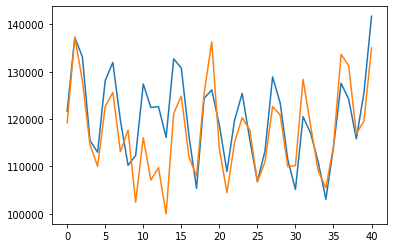

In [43]:
print(forecast_valid)
print(y_valid.values)
plt.plot(range(len(forecast_valid)),forecast_valid)
plt.plot(range(len(forecast_valid)),y_valid)
mape=np.mean(abs(np.array(forecast_valid)-np.array(y_valid))/np.array(y_valid))
mse=mean_squared_error(y_valid,forecast_valid)
raiz= np.sqrt(mse)
r2=r2_score(y_valid,forecast_valid)

print(mape)
print(mse)
print(r2)
print(raiz)

In [69]:
modelo_rf= RandomForestRegressor(n_estimators=3,max_depth=50)
modelo_rf.fit(x_entrenamiento,y_entrenamiento)
#print(y_entrenamiento)
prediccion=[]
real=[]
cache=x_valid.iloc[[0]].copy()
for i in range(len(x_valid)):
    y_prediccion= modelo_rf.predict(cache).item(0)
    prediccion.append(y_prediccion)
    nuevo_z=(y_prediccion-promedios["FOODS_3"])/desviacion["FOODS_3"]
    cache.loc[:,["sales_2","sales_3","sales_4","sales_5"]]=cache.loc[:,["sales_1","sales_2","sales_3","sales_4"]].values[0]
    cache["sales_1"]=nuevo_z
    if len (x_valid)>i+1:
        cache.iloc[0,0:56]=x_valid.iloc[i+1,0:56]
    real.extend(y_valid .tolist())
    
mape=np.mean(abs(np.array(prediccion)-np.array(y_valid))/np.array(y_valid))
print(mape)    

0.09529683694280844


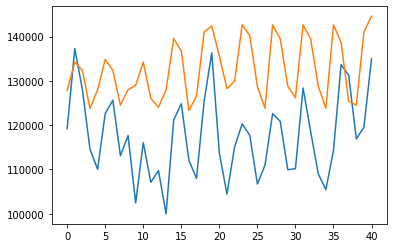

In [67]:
plt.plot(range(len(y_valid)),y_valid)
plt.plot(range(len(y_valid)),prediccion)
plt.show()

In [70]:
x_total

,year,semana,time,sell_price,1.0,2.0,3.0,4.0,5.0,6.0,...,48.0,49.0,50.0,51.0,52.0,sales_1,sales_2,sales_3,sales_4,sales_5
37,-1.569503,0.085131,-1.637751,-0.806885,0,0,0,0,0,0,...,0,0,0,0,0,2.098712,0.441565,0.528350,1.774675,2.246826
44,-1.569503,0.151019,-1.620602,-0.900078,0,0,0,0,0,0,...,0,0,0,0,0,0.616899,2.098712,0.441565,0.528350,1.774675
51,-1.569503,0.216906,-1.603453,-0.866266,0,0,0,0,0,0,...,0,0,0,0,0,-0.120730,0.616899,2.098712,0.441565,0.528350
58,-1.569503,0.282793,-1.586304,-0.832085,0,0,0,0,0,0,...,0,0,0,0,0,-0.830131,-0.120730,0.616899,2.098712,0.441565
65,-1.569503,0.348680,-1.569154,-0.893993,0,0,0,0,0,0,...,0,0,0,0,0,0.984874,-0.830131,-0.120730,0.616899,2.098712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,0.960068,-0.244304,0.951782,1.367326,0,0,0,0,0,0,...,0,0,0,0,0,-0.877515,-1.618421,-1.320260,-0.520293,0.308322
1101,0.960068,-0.178417,0.968931,1.405076,0,0,0,0,0,0,...,0,0,0,0,0,0.751571,-0.877515,-1.618421,-1.320260,-0.520293
1108,0.960068,-0.112530,0.986081,1.380019,0,0,0,0,0,0,...,0,0,0,0,0,0.549185,0.751571,-0.877515,-1.618421,-1.320260
1115,0.960068,-0.046643,1.003230,1.372289,0,0,0,0,0,0,...,0,0,0,0,0,-0.658242,0.549185,0.751571,-0.877515,-1.618421


In [117]:
foodz_total=pd.concat([foodz_entrenamiento,foodz_validacion,foodz_prueba])
x_total= foodz_total.drop("sales",axis=1)
y_total=foodz_total["sales"]
modelo_final_final=linear_model.LinearRegression()
modelo_final_final.fit(x_total,y_total)

data_2016=dep_semana[(dep_semana["year_final"]==2016)&(dep_semana["semana"]>0)]
year= [2016 for i in range (52)]
semana=[i+1 for i in range (52)]
tiempo=np.array(year)+(np.array(semana)-1)/52
sell_price=[2.913829 for i in range (52)]
df_2016= pd.DataFrame({"year":year,"semana":semana,"time":tiempo,"sell_price":sell_price})
semana=pd.get_dummies(df_2016["semana"])

df_completo=pd.concat([df_2016,semana],axis=1)
df_completo=df_completo[df_completo["semana"]>=17.0]



mean_year= todas_var["year"].mean()
mean_semana= todas_var["semana"].mean()
mean_sales= todas_var["sales"].mean()
mean_sell_price= todas_var["sell_price"].mean()
std_year= todas_var["year"].std()
std_semana= todas_var["semana"].std()
std_sales= todas_var["sales"].std()
std_sell_price= todas_var["sell_price"].std()
x_normal=df_completo.copy()
x_normal["year"]=(x_normal["year"]-mean_year)/std_year
x_normal["semana"]=(x_normal["semana"]-mean_semana)/std_semana
x_normal["sell_price"]=(x_normal["sell_price"]-mean_sell_price)/std_sell_price
mean_tiempo=todas_var["time"].mean()
std_tiempo=todas_var["time"].std()
x_normal["time"]=(x_normal["time"]-mean_tiempo)/std_tiempo


ventas_pasadas=y_total.iloc[-5:]
cache=x_normal.iloc[[0]].copy()
cache["sales_1"]=(ventas_pasadas.iloc[4]-promedios["FOODS_3"])/desviacion["FOODS_3"]
cache["sales_2"]=(ventas_pasadas.iloc[3]-promedios["FOODS_3"])/desviacion["FOODS_3"]
cache["sales_3"]=(ventas_pasadas.iloc[2]-promedios["FOODS_3"])/desviacion["FOODS_3"]
cache["sales_4"]=(ventas_pasadas.iloc[1]-promedios["FOODS_3"])/desviacion["FOODS_3"]
cache["sales_5"]=(ventas_pasadas.iloc[0]-promedios["FOODS_3"])/desviacion["FOODS_3"]

prediccion_final=[]
#print(cache)
for i in range(len(x_normal)):
    y_prediccion=modelo_final_final.predict(cache).item(0)
    print(y_prediccion)
    prediccion_final.append(y_prediccion)
    nuevo_z=(y_prediccion-promedios["FOODS_3"])/desviacion["FOODS_3"]
    cache.loc[:,["sales_2","sales_3","sales_4","sales_5"]]=cache.loc[:,["sales_1","sales_2","sales_3","sales_4"]].values[0]
    cache["sales_1"]=nuevo_z
    if len(x_normal)>i+1:
       cache.iloc[0,0:56]=x_normal.iloc[i+1,0:56]
#print(modelo_final_final.predict(x_total))

#print(x_normal.columns)
#print(x_total.columns)


-8869936765016.0
-14103663257460.0
-17530323617753.0
-18179075388445.0
-19052031163956.0
-19098357935309.0
-18724842337608.0
-17458707873861.0
-15786918268673.0
-13646867775208.0
-11214851323003.0
-8432271981029.0
-5394357975392.0
-2110080949243.0
1361026641601.0
5007538189331.0
8796960694997.0
12715291184051.0
16740072404605.0
20858682538638.0
25056317280333.0
29323012080646.0
33648332137517.0
38024456657713.0
42443918997649.0
46900817851562.0
51389756087701.0
55906304506803.0
60446517612555.0
65007097595431.0
69585152772414.0
74178237223382.0
78784224039272.0
83401302255250.0
88027905373954.0
92662694575031.0


In [114]:
print(modelo_final_final.coef_)

[ 4.14647574e+12 -5.59444559e+15 -3.92063940e+12 -1.25193359e+03
 -2.87457311e+15 -2.50590363e+15 -2.13723416e+15 -1.76856469e+15
 -1.39989522e+15 -1.03122575e+15 -6.62556275e+14 -2.93886803e+14
  7.47826695e+13  4.43452142e+14  8.12121614e+14  1.18079109e+15
  1.54946056e+15  1.91813003e+15  2.28679950e+15  2.65546897e+15
  3.02413845e+15  3.39280792e+15  3.76147739e+15  4.13014686e+15
  4.49881633e+15  4.86748581e+15  5.23615528e+15  5.60482475e+15
  5.97349422e+15  6.34216369e+15  6.71083317e+15  7.07950264e+15
  7.44817211e+15  7.81684158e+15  8.18551105e+15  8.55418053e+15
  8.92285000e+15  9.29151947e+15  9.66018894e+15  1.00288584e+16
  1.03975279e+16  1.07661974e+16  1.11348668e+16  1.15035363e+16
  1.18722058e+16  1.22408752e+16  1.26095447e+16  1.29782142e+16
  1.33468837e+16  1.37155531e+16  1.40842226e+16  1.44528921e+16
  1.48215616e+16  1.51902310e+16  1.55589005e+16  1.59275700e+16
  8.24950000e+03  9.56875000e+02 -1.65487500e+03  2.40100000e+03
 -3.71000000e+02]


In [115]:
for i in cache.columns:
    print(i,cache[i])

year 16    1.79879
Name: year, dtype: float64
semana 16    1.662294
Name: semana, dtype: float64
time 16    2.335068
Name: time, dtype: float64
sell_price 16    1.645462
Name: sell_price, dtype: float64
1 16    0.0
Name: 1, dtype: float64
2 16    0.0
Name: 2, dtype: float64
3 16    0.0
Name: 3, dtype: float64
4 16    0.0
Name: 4, dtype: float64
5 16    0.0
Name: 5, dtype: float64
6 16    0.0
Name: 6, dtype: float64
7 16    0.0
Name: 7, dtype: float64
8 16    0.0
Name: 8, dtype: float64
9 16    0.0
Name: 9, dtype: float64
10 16    0.0
Name: 10, dtype: float64
11 16    0.0
Name: 11, dtype: float64
12 16    0.0
Name: 12, dtype: float64
13 16    0.0
Name: 13, dtype: float64
14 16    0.0
Name: 14, dtype: float64
15 16    0.0
Name: 15, dtype: float64
16 16    0.0
Name: 16, dtype: float64
17 16    0.0
Name: 17, dtype: float64
18 16    0.0
Name: 18, dtype: float64
19 16    0.0
Name: 19, dtype: float64
20 16    0.0
Name: 20, dtype: float64
21 16    0.0
Name: 21, dtype: float64
22 16    0.0
Name